# Film Plot Synopses (and stuff) as Predictors of Critical Reception

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import enchant
english_d = enchant.Dict("en_US")
import re
import gensim
from gensim import corpora, models, similarities
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pyLDAvis
import pyLDAvis.gensim

In [2]:
imdb = pd.read_csv('imdb_5000_movies.csv') # Just a Kaggle dataset.

The best part of this kaggle dataset is that it provides 5k+ IMdB movie ID's, which we parse and pass to the Open Movie Database API for an even richer data set. Keys to this API cost a whole dollar. Here we parse out those IMdB ID's.

In [3]:
imdb_ids = [imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0] for i in range(len(imdb))]

### Insert code into omdb api and turn each one into its own text file

This is where we persist our API queries to files, so that we don't run into query limits and get locked out of our dataset. Our API key has been removed from this notebook.

In [4]:
# for id in imdb_ids:

#     request = requests.get(f'http://www.omdbapi.com/?i={id}&plot=full&apikey={API_KEY}').json()
#     text = str(request)  
    
#     f = open(f'movie_{id}', 'w+')
#     f.write(text)
#     f.close()

### Create new dataframe with relevant columns

Now that we've saved a bunch of files containing data about movies, we'll read them back into pandas in a tidy way:

In [5]:
#create empty dataframe with relevant columns

df = pd.DataFrame(columns=['Title', 'Year', 'ID', 'Plot', 'Genre', 'Production', 
                           'Director', 'Actor_1_name', 'Actor_1_fb_likes', 'Actor_2_name', 
                           'Actor_2_fb_likes', 'Actor_3_name', 'Actor_3_fb_likes', 'Budget', 
                           'Rated', 'Language', 'imdbRating'])

### Drawing from both the kaggle dataset and the OMdB API Data

In [6]:
for i in range(len(imdb_ids)):
    id = imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0]
    x_file = open(os.path.join('Movies', f"movie_{id}"), "r")    #open up the movie's text file
    movie_text = x_file.readlines()[0]
    dict = eval(movie_text)    #turn string back to dictionary
    dict['Plot'] = dict['Plot'].replace("\'", "'")    #clean up
    df = df.append({'Title': dict['Title'], 'Year': dict['Year'], 'ID': id, 
                    'Plot': dict['Plot'], 'Genre': dict['Genre'], 
                    'imdbRating': dict['imdbRating'], 
                    'Director': imdb.iloc[i,:].loc['director_name'], 
                    'Actor_1_name':imdb.iloc[i,:].loc['actor_1_name'], 
                    'Actor_1_fb_likes':imdb.iloc[i,:].loc['actor_1_facebook_likes'], 
                    'Actor_2_name':imdb.iloc[i,:].loc['actor_2_name'], 
                    'Actor_2_fb_likes':imdb.iloc[i,:].loc['actor_2_facebook_likes'], 
                    'Actor_3_name':imdb.iloc[i,:].loc['actor_3_name'], 
                    'Actor_3_fb_likes':imdb.iloc[i,:].loc['actor_3_facebook_likes'], 
                    'Budget':imdb.iloc[i,:].loc['budget'], 'Language':dict['Language'], 
                    'Rated':dict['Rated']}, ignore_index=True)    #add to dataframe

### Parsing out Genres as one-hot Columns:

In [7]:
li = []
for i in range(len(df)):
    movie_genres = df.iloc[i]['Genre'].split(', ')
    li.append(movie_genres)
    
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

for genre in final_genres:
    list = []
    for movie in li:
        if genre in movie:
            list.append(1)
        else:
            list.append(0)
    df[genre] = list

### Remove movies with null plots and ratings, convert ratings into binary

In [8]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)


In [9]:
df = df.reset_index()

In [10]:
df = df.drop(['index'], axis=1)

In [11]:
df[:3]

Title  Year         ID  \
0                                    Avatar  2009  tt0499549   
1  Pirates of the Caribbean: At World's End  2007  tt0449088   
2                                   Spectre  2015  tt2379713   

                                                Plot  \
0  When his brother is killed in a robbery, parap...   
1  After Elizabeth, Will, and Captain Barbossa re...   
2  A cryptic message from the past sends James Bo...   

                                Genre  Production        Director  \
0  Action, Adventure, Fantasy, Sci-Fi         NaN   James Cameron   
1          Action, Adventure, Fantasy         NaN  Gore Verbinski   
2         Action, Adventure, Thriller         NaN      Sam Mendes   

      Actor_1_name  Actor_1_fb_likes      Actor_2_name      ...        Horror  \
0      CCH Pounder            1000.0  Joel David Moore      ...             0   
1      Johnny Depp           40000.0     Orlando Bloom      ...             0   
2  Christoph Waltz           11000.0      Rory Kinnear      ...             0   

  Musical  Mystery  Romance Sci_Fi Sport  Thriller  War  Western  \
0       0        0        0      0     0         0    0        0   
1       0        0        0      0     0         0    0        0   
2       0        0        0      0     0         1    0        0   

   binary_target  
0              1  
1              1  
2              1  

[3 rows x 38 columns]

### Creating a fresh DataFrame with Just the Features we Want

In [12]:
main_df = pd.DataFrame()

In [13]:
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

In [14]:
main_df[:3]

Year  Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
0  2009       1          1          0          0       0      0            0   
1  2007       1          1          0          0       0      0            0   
2  2015       1          1          0          0       0      0            0   

   Drama  Family      ...        Horror  Musical  Mystery  Romance  Sci_Fi  \
0      0       0      ...             0        0        0        0       0   
1      0       0      ...             0        0        0        0       0   
2      0       0      ...             0        0        0        0       0   

   Sport  Thriller  War  Western  binary_target  
0      0         0    0        0              1  
1      0         0    0        0              1  
2      0         1    0        0              1  

[3 rows x 22 columns]

In [15]:
df.plot.scatter(x='Actor_1_fb_likes',
                    y='imdbRating') # Just spotting some outliers...this prompted us to log transform fb_likes

### Log Transforming Actor Facebook Likes for use as a Feature

In [16]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

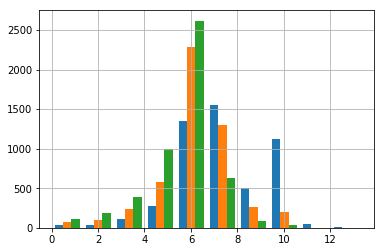

In [17]:
pd.Series(actor_likes).hist()

In [18]:
main_df = main_df.join(actor_likes)

In [19]:
main_df[:3]

Year  Action  Adventure  Animation  Biography  Comedy  Crime  Documentary  \
0  2009       1          1          0          0       0      0            0   
1  2007       1          1          0          0       0      0            0   
2  2015       1          1          0          0       0      0            0   

   Drama  Family           ...             Romance  Sci_Fi  Sport  Thriller  \
0      0       0           ...                   0       0      0         0   
1      0       0           ...                   0       0      0         0   
2      0       0           ...                   0       0      0         1   

   War  Western  binary_target  Actor_1_fb_likes_logged  \
0    0        0              1                 6.908755   
1    0        0              1                10.596660   
2    0        0              1                 9.305741   

   Actor_2_fb_likes_logged  Actor_3_fb_likes_logged  
0                 6.842683                 6.752270  
1                 8.517393                 6.908755  
2                 5.976351                 5.087596  

[3 rows x 25 columns]

### Incorporating Natural Language Processing with Plot Synopses

#### Setting up Lemmatization / Normalization Functions

In [20]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(plot_list):
    lemmatized_plots = []
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower())   #make plot summary all lowercase and lemmatize
        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        
        lemmatizer = WordNetLemmatizer()
        
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower]    #lemmatize each word based on part of speech
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        #filter for words that match regex pattern
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))    #define regular expression pattern
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        #filter out stop words
        stop_words = set(stopwords.words('english'))
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        
        lemmatized_plots.append(lemmatized_string)
        
        
    return lemmatized_plots

In [21]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all the plots.

### Running the Lemmatizer

In [22]:
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [23]:
#term frequency = number of times a word appears in a document / number of words in document
#inverse document frequency = log base e(number of ducuments / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

(5037, 13807)


Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA - Clustering Documents by Topic

We tried running a topic modeling algorithm over our corpus of text. "Gensim" clusters words that appear together frequently across several documents. The clusters can be interpreted as general themes, and each movie has weights of how much it belongs to each theme. These weights are then re-incorporated as features in our dataset.

In [24]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [25]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [26]:
NUM_TOPICS = 30 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('model5.gensim')

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/rob/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogt

In [27]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

[(7, '0.015*"documentary" + 0.010*"friend" + 0.009*"make" + 0.009*"go"'),
 (5, '0.008*"england" + 0.008*"tommy" + 0.007*"life" + 0.007*"massacre"'),
 (22, '0.017*"game" + 0.010*"video" + 0.007*"world" + 0.007*"new"'),
 (16, '0.018*"town" + 0.014*"life" + 0.012*"new" + 0.010*"find"'),
 (23, '0.010*"city" + 0.008*"force" + 0.008*"food" + 0.008*"control"'),
 (1, '0.027*"bond" + 0.013*"henry" + 0.010*"child" + 0.010*"evil"'),
 (12, '0.015*"get" + 0.014*"life" + 0.012*"time" + 0.010*"one"'),
 (0, '0.021*"nick" + 0.020*"get" + 0.015*"money" + 0.014*"max"'),
 (21, '0.022*"earth" + 0.019*"human" + 0.017*"alien" + 0.012*"planet"'),
 (15, '0.013*"man" + 0.010*"one" + 0.010*"kill" + 0.009*"find"'),
 (8, '0.016*"life" + 0.010*"one" + 0.008*"find" + 0.008*"make"'),
 (2, '0.022*"band" + 0.019*"rock" + 0.014*"singer" + 0.012*"star"'),
 (6, '0.013*"begin" + 0.010*"take" + 0.007*"tom" + 0.006*"strange"'),
 (19, '0.017*"prison" + 0.014*"police" + 0.010*"frank" + 0.010*"try"'),
 (10, '0.013*"life" + 0.01

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/Users/rob/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.063000  0.133661       1        1  10.512887
12    -0.160513  0.016448       2        1  10.432733
24    -0.187722 -0.027441       3        1   7.629699
18    -0.193207 -0.028290       4        1   7.578108
9     -0.106272  0.061476       5        1   5.394047
26    -0.130555 -0.021110       6        1   4.752414
8     -0.083169  0.025380       7        1   4.665955
16    -0.118405 -0.013149       8        1   3.620172
21     0.080925  0.203790       9        1   3.484607
29     0.089715  0.156581      10        1   3.184179
10    -0.013318  0.012889      11        1   3.074202
19     0.026423  0.069527      12        1   2.536774
13     0.023282 -0.017824      13        1   2.465806
7     -0.058945 -0.055679      14        1   2.443244
22    -0.000110  0.034186      15        1   2.297895
27    -0.036721 -0.039983      16        1   2.203848
23     0.167352  0.127613      17        1   2.171393
17     0.043584  0.033381      18        1   2.144970
14     0.001380 -0.069066      19        1   2.055811
3      0.068746  0.036038      20        1   1.989818
20    -0.014311 -0.027665      21        1   1.925796
0     -0.037235 -0.081025      22        1   1.882889
11     0.011373 -0.066864      23        1   1.767948
1      0.071476  0.067887      24        1   1.743947
4     -0.000639 -0.043614      25        1   1.716342
6      0.050257 -0.132975      26        1   1.489722
5      0.096119 -0.038310      27        1   1.482536
2      0.145250 -0.077821      28        1   1.371227
25     0.127181 -0.068243      29        1   1.168870
28     0.201058 -0.169798      30        1   0.812164, topic_info=      Category         Freq          Term        Total  loglift  logprob
term                                                                    
359    Default   553.000000        school   553.000000  30.0000  30.0000
460    Default  1367.000000           get  1367.000000  29.0000  29.0000
244    Default   815.000000        father   815.000000  28.0000  28.0000
2124   Default   481.000000          film   481.000000  27.0000  27.0000
212    Default  1974.000000          life  1974.000000  26.0000  26.0000
248    Default  1125.000000        friend  1125.000000  25.0000  25.0000
658    Default   511.000000          town   511.000000  24.0000  24.0000
1149   Default  1038.000000        family  1038.000000  23.0000  23.0000
332    Default   230.000000         earth   230.000000  22.0000  22.0000
203    Default  1102.000000            go  1102.000000  21.0000  21.0000
313    Default   575.000000        mother   575.000000  20.0000  20.0000
230    Default   377.000000           war   377.000000  19.0000  19.0000
544    Default   420.000000          team   420.000000  18.0000  18.0000
607    Default   345.000000          high   345.000000  17.0000  17.0000
2141   Default   285.000000       student   285.000000  16.0000  16.0000
739    Default   230.000000         movie   230.000000  15.0000  15.0000
188    Default   344.000000        police   344.000000  14.0000  14.0000
761    Default   735.000000         story   735.000000  13.0000  13.0000
284    Default   975.000000         young   975.000000  12.0000  12.0000
68     Default   823.000000         world   823.000000  11.0000  11.0000
34     Default   939.000000          love   939.000000  10.0000  10.0000
676    Default   248.000000         human   248.000000   9.0000   9.0000
696    Default   519.000000          girl   519.000000   8.0000   8.0000
3336   Default   293.000000         money   293.000000   7.0000   7.0000
270    Default   410.000000  relationship   410.000000   6.0000   6.0000
754    Default   228.000000          game   228.000000   5.0000   5.0000
3678   Default   188.000000         frank   188.000000   4.0000   4.0000
7      Default   128.000000          bond   128.000000   3.0000   3.0000
853    Default   900.000000           t

In [29]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(30)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [30]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

0         1         2    3         4    5    6    7    8         9   \
0  0.0  0.048436  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000   
1  0.0  0.000000  0.117099  0.0  0.032573  0.0  0.0  0.0  0.0  0.320685   
2  0.0  0.187716  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000   
3  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.052928   
4  0.0  0.000000  0.028033  0.0  0.000000  0.0  0.0  0.0  0.0  0.109865   

     ...      20        21   22        23   24   25        26   27   28  \
0    ...     0.0  0.100674  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0   
1    ...     0.0  0.000000  0.0  0.165501  0.0  0.0  0.030473  0.0  0.0   
2    ...     0.0  0.000000  0.0  0.189697  0.0  0.0  0.000000  0.0  0.0   
3    ...     0.0  0.000000  0.0  0.233626  0.0  0.0  0.000000  0.0  0.0   
4    ...     0.0  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0   

         29  
0  0.158050  
1  0.074288  
2  0.000000  
3  0.000000  
4  0.113035  

[5 rows x 30 columns]

### Joining GenSim Results with Vectorized Plot Synopses

In [31]:
plots_and_topics = tfidf_df.join(tm)

In [32]:
plots_and_topics.head()

aardvark  aback  abandon  abandonment  abate  abatement  abbey  abdicate  \
0       0.0    0.0      0.0          0.0    0.0        0.0    0.0       0.0   
1       0.0    0.0      0.0          0.0    0.0        0.0    0.0       0.0   
2       0.0    0.0      0.0          0.0    0.0        0.0    0.0       0.0   
3       0.0    0.0      0.0          0.0    0.0        0.0    0.0       0.0   
4       0.0    0.0      0.0          0.0    0.0        0.0    0.0       0.0   

   abduct  abduction    ...      20        21   22        23   24   25  \
0     0.0        0.0    ...     0.0  0.100674  0.0  0.000000  0.0  0.0   
1     0.0        0.0    ...     0.0  0.000000  0.0  0.165501  0.0  0.0   
2     0.0        0.0    ...     0.0  0.000000  0.0  0.189697  0.0  0.0   
3     0.0        0.0    ...     0.0  0.000000  0.0  0.233626  0.0  0.0   
4     0.0        0.0    ...     0.0  0.000000  0.0  0.000000  0.0  0.0   

         26   27   28        29  
0  0.000000  0.0  0.0  0.158050  
1  0.030473  0.0  0.0  0.074288  
2  0.000000  0.0  0.0  0.000000  
3  0.000000  0.0  0.0  0.000000  
4  0.000000  0.0  0.0  0.113035  

[5 rows x 13837 columns]

# EDA with Non-PlotText Features

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as sm
from patsy import dmatrices

In [34]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588562
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                           23
Date:                Tue, 08 Jan 2019   Pseudo R-squ.:                  0.1485
Time:                        22:49:17   Log-Likelihood:                -2371.3
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                7.246e-160
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.6656      6.990     12.255      0.000      71.965   

0.6865079365079365

In [35]:
# Rerun LogReg by dropping the features with high p_values in the prior model (see above)

s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state=16)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588716
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4013
Method:                           MLE   Df Model:                           15
Date:                Tue, 08 Jan 2019   Pseudo R-squ.:                  0.1482
Time:                        22:49:17   Log-Likelihood:                -2371.9
converged:                       True   LL-Null:                       -2784.7
                                        LLR p-value:                2.871e-166
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  85.2044      6.931     12.293      0.000      71.620   

0.6884920634920635

In [36]:
main_df.columns

Index(['Year', 'Action', 'Animation', 'Biography', 'Comedy', 'Documentary',
       'Drama', 'Family', 'Horror', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller',
       'binary_target', 'Actor_1_fb_likes_logged', 'Actor_2_fb_likes_logged',
       'Actor_3_fb_likes_logged'],
      dtype='object')

## Dimensionality Reduction with SVD - For the PlotText Data

In [37]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=14, n_iter=3, random_state=42)
plots_and_topics_pca = pd.DataFrame(svd.fit_transform(plots_and_topics))

print(svd.explained_variance_ratio_.sum())

0.1688771204574009


## Joining PlotText and Other Features

In [38]:
df = main_df.join(plots_and_topics_pca)
len(df.columns)

31

## Advanced Models

In [39]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [40]:
X = df.drop(['binary_target'], axis=1)

In [41]:
y = df.binary_target

In [42]:
scaler = StandardScaler()

In [43]:
X_scaled = scaler.fit_transform(X)

/Users/rob/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rob/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.1, random_state=15)
# X_train

In [45]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 74.48%
Test accuracy: 71.03%


In [46]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('reduce_dim', TruncatedSVD()),
    ('classify', xgb.XGBClassifier())  
])

score = {'f1': 'f1', 'accuracy': 'accuracy'}

N_FEATURES_OPTIONS = [7, 10, 13, 14, 15]

itera = [3, 5, 7]
max_dep = [2,3,4,5]
n_est = [50,80,100,120,150]
min_samp = [4,5,6,10]

param_grid = [
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
        'classify__max_depth': max_dep,
        'classify__min_samples_split':min_samp
    }]

reducer_labels = ['TruncatedSVD']

grid_adc = GridSearchCV(pipe, cv=None, n_jobs=-1, param_grid=param_grid, scoring=score, refit='accuracy')
grid_adc.fit(X_train, y_train)
grid_adc.best_params_

/Users/rob/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'classify__max_depth': 5,
 'classify__min_samples_split': 5,
 'classify__n_estimators': 50,
 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=13, n_iter=3,
        random_state=None, tol=0.0),
 'reduce_dim__n_components': 13,
 'reduce_dim__n_iter': 3}

In [47]:
y_preds = grid_adc.predict(X_test)

In [48]:
accuracy_score(y_test,y_preds)

0.6984126984126984